In [9]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

# Generate data

In [79]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # `gamma(n)` = (n-1)!
# `labels`的维度: (`n_train` + `n_test`,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [80]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    d2l.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-0.4085],
         [-0.0665]]),
 tensor([[ 1.0000e+00, -4.0853e-01,  8.3448e-02, -1.1364e-02,  1.1606e-03,
          -9.4826e-05,  6.4565e-06, -3.7681e-07,  1.9242e-08, -8.7344e-10,
           3.5682e-11, -1.3252e-12,  4.5115e-14, -1.4178e-15,  4.1371e-17,
          -1.1267e-18,  2.8769e-20, -6.9136e-22,  1.5691e-23, -3.3738e-25],
         [ 1.0000e+00, -6.6526e-02,  2.2128e-03, -4.9070e-05,  8.1610e-07,
          -1.0858e-08,  1.2039e-10, -1.1442e-12,  9.5146e-15, -7.0329e-17,
           4.6787e-19, -2.8296e-21,  1.5687e-23, -8.0274e-26,  3.8145e-28,
          -1.6917e-30,  7.0340e-33, -2.7526e-35,  1.0173e-37, -3.5620e-40]]),
 tensor([4.0631, 4.8356]))

In [81]:
def evaluate_loss(model, data_iter, loss):
    '''evaluation loss'''
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = model(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1] # it is the average loss

In [82]:
def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    
    model = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    
    batch_size = min(32, train_labels.shape[0]) # in case there is not enough data
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)), batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)), batch_size, is_train=False)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(model, train_iter, loss, optimizer)
        if epoch==0 or (epoch+1)%20==0:
            animator.add(epoch + 1, (evaluate_loss(model, train_iter, loss),
                                     evaluate_loss(model, test_iter, loss)))
    print('weight:', model[0].weight.data.numpy())

# A proper model

weight: [[ 4.9556847  1.3816592 -3.2263083  5.208736 ]]


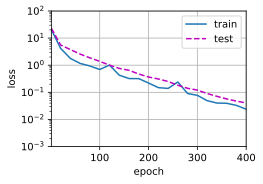

In [83]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4], labels[:n_train], labels[n_train:])

# Underfitting--model compl

weight: [[3.785939  3.3013854]]


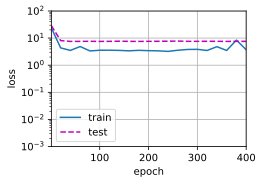

In [84]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2], labels[:n_train], labels[n_train:])

# Overfitting

weight: [[ 4.99237919e+00  1.51862955e+00 -3.38469887e+00  4.46010256e+00
   1.33802384e-01  1.53700471e+00  2.24384204e-01  1.55994982e-01
   3.45989683e-04 -7.14383945e-02 -1.01350710e-01  1.24140546e-01
   6.25091791e-02  8.33573714e-02  1.74753934e-01 -9.04724561e-03
   1.65505573e-01  6.36755526e-02 -9.80935916e-02 -1.80984721e-01]]


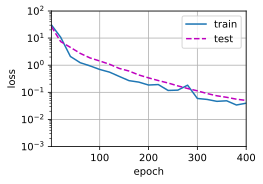

In [85]:
train(poly_features[:n_train, :], poly_features[n_train:, :], labels[:n_train], labels[n_train:])